# Basic Instructions

1. Enter your Name and UID in the provided space.
2. **Download the data file [here](https://umd.instructure.com/files/80453154/download?download_frd=1). Make sure that you are logged in to ELMS before downloading.**
3. Do the assignment in the notebook itself.
4. You are free to use Google Colab.
5. Upload to Google Drive.
6. Now, enter the Google Drive link in the provided space. (you can do this by opening the iPython notebook uploaded using Google Collab).
7. Feel free to refer to the Neural Network tutorial and the PyTorch tutorial included with the TA lecture material. 
8. Submit the assignment to Gradescope, and a results file to ELMS.

# Homework Overview

In this assignment, you will learn PyTorch while trying to create a bird vs. non-bird classifier. More specifically, you will
1. Write a Dataset class in PyTorch.
2. Define a neural network in PyTorch.
3. Implement training and testing loops in PyTorch.
4. Find a way to improve the performance of your network above our baseline.
5. Compete for the best performance on a held-out testset.
6. Provide both a written description and a graphical justification of your approach.

# Challenge Description

This assignment is a challenge. How exciting! As in Homework 2, this is a binary classification problem, where your network will learn to discriminate birds from other things. We have curated a special dataset, new to this assignment, consisting of birds and non-birds. As before, we provide you with train and validation images and labels. However, for the test set, we only give you test images! (No labels!) Your goal is to try to get the best classification performance in the class on these test images.

# Leaderboard 

Things just got more interesting! The top-10 testset accuracies in class will be displayed in a leaderboard which will be updated twice:
1. Intermediate round: Submit your `challenge_3_results_nickname.pth` from exercise 8 to ELMS by **Oct. 16 5.00pm**. Find the nickname rules under section 8.
2. Final round: With your final submission.

**Submissions with the top-3 accuracies in class on the *testset* during the *final round* will win lucrative ~~cash prizes~~ bonus points!**

* **Winner:** 20 bonus points 
* **Runners-up:** 10 bonus points 
* **Second Runners-up:** 5 bonus points 

**Submissions with the top-3 accuracies in class on the *testset* during the *intermediate round* will win 5 bonus points each!**


# Challenge Rules

1. You **MUST** submit a results file on ELMS. Details are provided in Section 8 of this notebook.
2. You **MAY NOT** deviate from neither of the **number of layers (2)** nor the **number of parameters (hidden layer size = 7)** in each layer from Assignment 2. Feel free to ask questions by making a *Public* post in either Piazza if you are unsure if a given change is allowed or not.
3. You **MAY NOT** attempt to manually label the test images. We want to evaluate the performance of your neural classification network, not your classification ability.
4. You should try to achieve at least **75%** validation accuracy (Baseline).

Name:  **Danylo Voloshyn**  
UID:  **118895499**

Link to Google Drive : **Link Here (make sure it works)**

Provide your code at the appropriate placeholders.

## 1. Packages

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import scipy
from PIL import Image
from scipy import ndimage
from tqdm import tqdm
import time

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

np.random.seed(42)

## 2. Dataset and Preprocessing

**Dataset Description**: 

In the provided torch file, you will find an object with the following keys, with corresponding shapes:

`train_images`: (400,64,64,3)

`train_labels`: (400)

`val_images`: (400,64,64,3)

`val_labels`: (400)

`test_images`: (400,64,64,3)

The values corresponding to `train_images`, `val_images`, and `test_images` are separate tensors, each containing 400 64 x 64 images. Each set of 400 images is comprised of 200 birds and 200 non-birds.

The values corresponding to `train_labels` and `val_labels` are tensors containing a list of integers, 1 or 0, to indicate whether an image is a bird (1) or non-bird (0). These are parallel to their corresponding image tensor. That is, the first label in `train_labels` corresponds to the first entry of `train_images`. 

Below, we give a quick peak into what the training set looks like!

train image shape: torch.Size([400, 64, 64, 3])
train labels shape: torch.Size([400])
labels: [0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1]


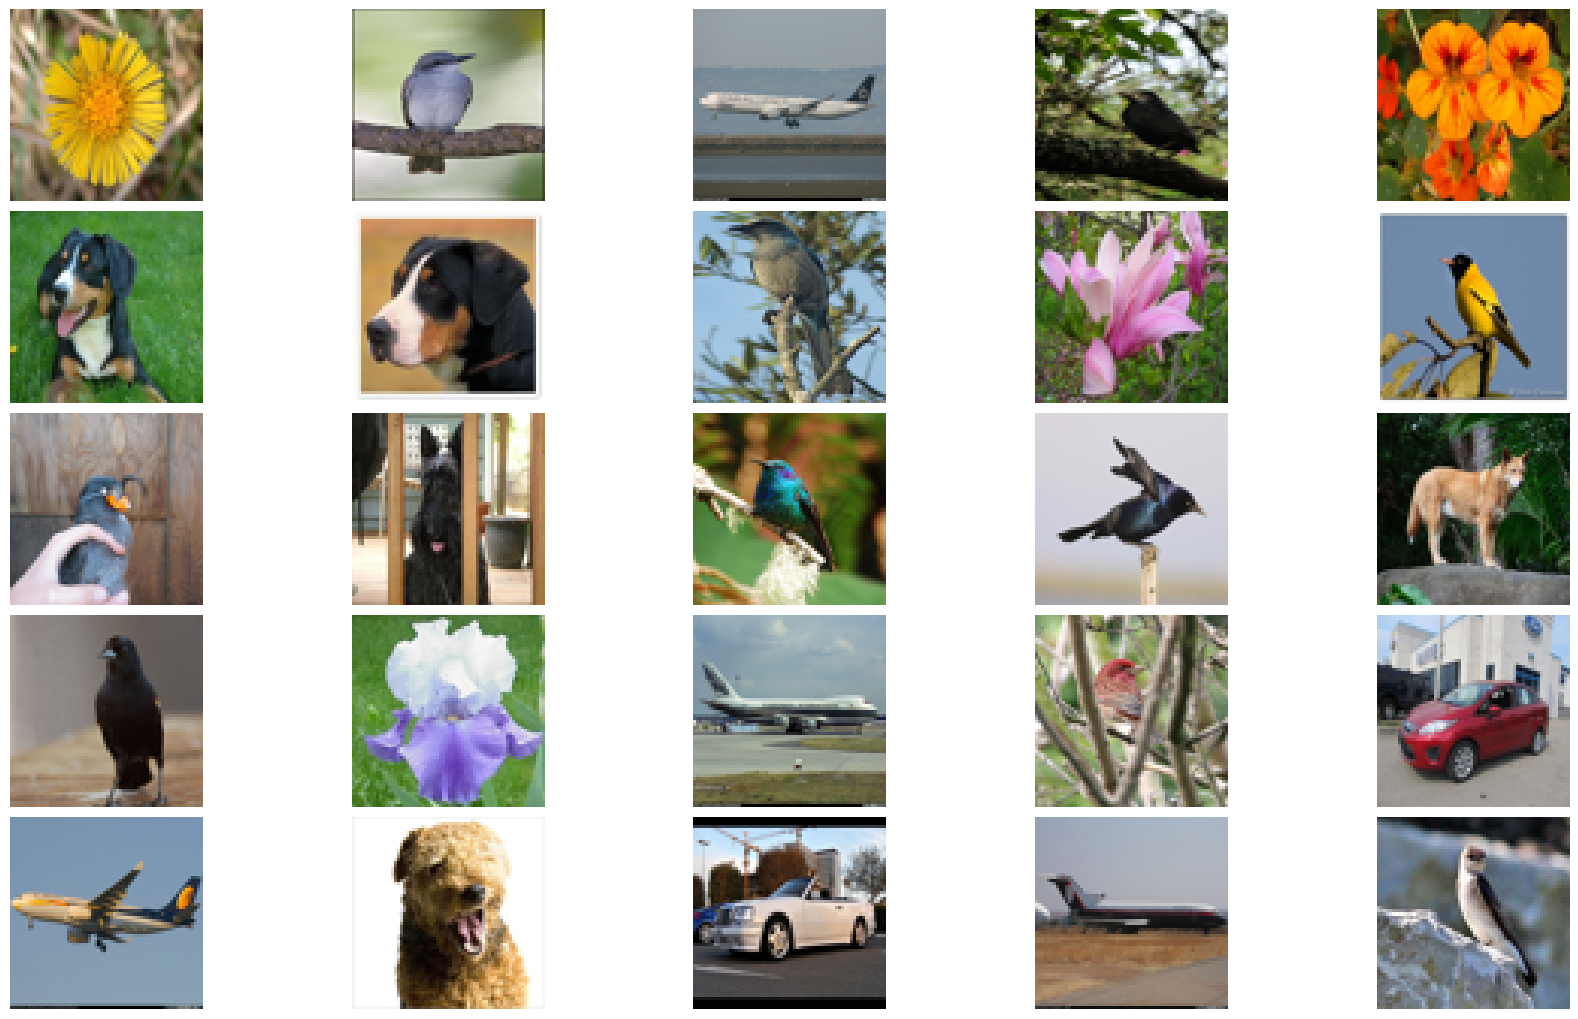

In [2]:
dataset = torch.load('toy_dataset.pth')

print('train image shape:', dataset['train_images'].shape)
print('train labels shape:', dataset['train_labels'].shape)


def plotToy(figName, images):
    fig = plt.figure(figsize=(20.5, 12)) 
    nrow = 5
    ncol = 5
    gs = gridspec.GridSpec(nrow, ncol,
         wspace=0.0, hspace=0.05, 
         top=1.-0.5/(nrow+1), bottom=0.5/(nrow+1), 
         left=0.5/(ncol+1), right=1-0.5/(ncol+1))

    i = 0
    for j in range(images.shape[0]):
        rgb_im = images[j].numpy().astype(np.uint8)

        ax = plt.subplot(gs[int(i / ncol), i % ncol])
        ax.imshow(rgb_im)
        ax.axis('off')
        i += 1

    plt.savefig(figName + '.png', bbox_inches='tight', pad_inches=0)
    
plotToy('toy_plot', dataset['train_images'][:25])
print("labels:", dataset['train_labels'][:25].tolist())

**PyTorch Dataset**: 

You will now implement a torch dataset that will be compatible with the dataloader code in Section 5. We give you part of the outline below, feel free to use the documentation (https://pytorch.org/docs/stable/_modules/torch/utils/data/dataset.html#Dataset) or a tutorial for more details.

<img src="imvectorkiank.png" style="width:450px;height:300px;">

<caption><center> <u>Figure 1</u>: Image to vector conversion. <br> </center></caption> <br>

**Exercise 1:** Complete the *BirdVNonBirdDataset* class which inherits the *torch.utils.data.Dataset* class and override the __\_\_len\_\___ and __\_\_getitem\_\___  methods. 

**Important:** Don't forget to reshape and standardize images as necessary before feeding them to the network!

In [3]:
class BirdVNonBirdDataset(Dataset):
    def __init__(self, file_name, mode = 'train'):
        self.file_name = file_name
        self.mode = mode
        data = torch.load(file_name)
        
        if self.mode == 'train':
            self.images = data['train_images']
            self.labels = data['train_labels']
        elif self.mode == 'val':
            self.images = data['val_images']
            self.labels = data['val_labels']
        elif self.mode == 'test':
            self.images = data['test_images']
        else:
            raise ValueError("Mode is not train, test, or val")
          
        ## read data from toy_dataset.pth and set up the code such that: 
        ##      - len will return the length
        ##      - __getitem__ will return the images, with labels depending on the mode
        ##      - don't forget the mode- load train images if train, test if test, etc.

    def __len__(self):
        ## Return number of images in the dataset
        return len(self.images)
    
    def __getitem__(self, idx):
        ## return image, and, if not test mode, the label at the given index
        ## valid formats include:
        ## {'image': image, 'label': label}
        ## image, label
        ## where image and label have both been converted to torch.Tensors
        
        image = self.images[idx]
        
        if self.mode == 'test':
            return image
        else:
            label = self.labels[idx]
            
            return image, label

In [4]:
class TransformedDataset(Dataset):
    def __init__(self, original_dataset, transform=None):
        self.original_dataset = original_dataset
        self.transform = transform

    def __len__(self):
        return len(self.original_dataset)

    def __getitem__(self, idx):
        image, label = self.original_dataset[idx]
        
        if self.transform:
            image = self.transform(image)

        return image, label

## 3. Architecture of your model

Now that you are familiar with the dataset, it is time to build a deep neural network to distinguish bird images from non-bird images.

###  2-layer neural network


We are going to use the same architecture as we used in HW02. The model can be summarized as: 

<center> <b> INPUT -> LINEAR -> RELU -> LINEAR -> SIGMOID -> OUTPUT </b> </center>


###  General methodology

As usual you will follow the Deep Learning methodology to build the model:

    1. Initialize parameters / Define hyperparameters
    2. Loop for num_iterations:
        a. Forward propagation
        b. Compute loss function
        c. Backward propagation an update parameters (using parameters, and grads from backprop) 
    3. Use trained parameters to predict labels

Let's now implement the model!

**Exercise 2:** Implement the neural network model.

**Important:** You MAY NOT deviate from neither of the **number of layers (2)** nor the **number of parameters (hidden layer size = 7)** in each layer from Assignment 2.

In [5]:
class Net(nn.Module):
    def __init__(self, input_size):
        super(Net, self).__init__()
        
        self.fc1 = nn.Linear(input_size, 7)
        self.fc2 = nn.Linear(7, 1)
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()
    
    def forward(self, x):
        x = x.view(-1, 12288)
        
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        x = self.sigmoid(x)
        
        return x

## 4. Define your hyperparamters

**Exercise 3:** Please make sure your final hyperparameters are in the cell below.

In [6]:
batch_size = 64
learning_rate = 0.01
epochs = 1000

## 5. Initialize the Dataloaders

**Exercise 4:** Initialize you dataloaders with instances of the dataset you defined in Section 2.

In [7]:
from torchvision import transforms

tr = {
  'train':transforms.Compose([]),
  'val':transforms.Compose([])
}

In [8]:
train_set = BirdVNonBirdDataset('toy_dataset.pth')
val_set = BirdVNonBirdDataset('toy_dataset.pth', mode='val')
test_set = BirdVNonBirdDataset('toy_dataset.pth', mode='test')

train_dataloader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(val_set, batch_size=batch_size, shuffle=False)
test_dataloader = DataLoader(test_set, batch_size=batch_size, shuffle=False) #DO NOT change the shuffle=False here!

In [9]:
def load_data(b):
  train_set = BirdVNonBirdDataset('toy_dataset.pth')
  val_set = BirdVNonBirdDataset('toy_dataset.pth', mode='val')
  test_set = BirdVNonBirdDataset('toy_dataset.pth', mode='test')

  train_dataloader = DataLoader(train_set, batch_size=b, shuffle=True)
  val_dataloader = DataLoader(val_set, batch_size=b, shuffle=False)
  test_dataloader = DataLoader(test_set, batch_size=b, shuffle=False) #DO NOT change the shuffle=False here!

## 6. Define the optimizer and loss function

In [10]:
model = Net(12288)  #making an instance of the network
optim = torch.optim.SGD(model.parameters(), lr=learning_rate)  #model.paramters() gives all the trainable paramters. 
loss_function = nn.BCELoss()

## 7. Defining the for loop for train and validation phase

### In each the phases certain things one has to be careful of:

- Training Phase:
  - Make sure the model is in train mode. That is ensured by `model.train()`

  - While looping over instances of a batch, make sure the graidents are always set to zero before calling the backward function. That's done by `optim.zero_grad()`. If this is not done, the gradients get accumulated.

  - Call the backward function on the loss by `loss.backward()` so that the loss get back propagated.

  - Call the step function of the optimiser to update the weights of the network. This is done by `optim.step()`

- Validation/Testing Phase
  - Make sure your model is in eval mode. This makes the model deterministic rather than probabilistic. This is ensured by `model.eval()`
  - As we don't need any gradients doing our validation/ testing phase, we can esnure that they are not calculated by defining a block with `torch.no_grad()`
  
**Exercise 5:** Implement the training and validation phases.

In [11]:

train_loss = []
val_loss = []

def train(lr, decay=0, momentum=0, gamma=1, seed=42):
  np.random.seed(seed)
  torch.manual_seed(seed)
  model = Net(12288)

  cur_lr = lr

  for epoch in range(epochs):
      if epoch % 10 == 9:
        cur_lr *= gamma
      if epoch % 100 == 99:
        cur_lr = lr
        
      optim = torch.optim.SGD(model.parameters(), lr=cur_lr, momentum=momentum, weight_decay=decay)
        
      # Training phase
      model.train()
      train_acc = 0.
      val_acc = 0.
      for idx, batch in enumerate(train_dataloader):
          optim.zero_grad()
          
          inputs, labels = batch
          
          inputs = F.normalize(inputs)
          labels = labels.float()

          outputs = model(inputs).squeeze()
          
          loss = loss_function(outputs, labels)   
          loss.backward()
          
          optim.step()
          
          predictions = outputs.data > 0.5
          train_acc += (predictions == labels).sum().item()
          train_loss.append(loss.item())

      train_acc /= len(train_dataloader.dataset)

      #Validation phase
      model.eval()  #Setting the model to eval mode, hence making it deterministic.
      for idx, batch in enumerate(val_dataloader):
          with torch.no_grad():   #Does not calulate the graidents, as in val phase its not needed. Saves on memory.
              inputs, labels = batch
              inputs = F.normalize(inputs)
              labels = labels.view(-1, 1).float()

              outputs = model(inputs)
              
              loss = loss_function(outputs, labels)
              
              predictions = outputs.data > 0.5
              val_acc += (predictions == labels).sum().item()
              val_loss.append(loss.item())
    
      val_acc /= len(val_dataloader.dataset)
      
        ## DO NOT change the next two lines
      if epoch%100==0:
        print("Epoch : {}, Train loss: {} , Train Acc: {}, Val loss: {}, Val acc: {}".format(epoch, np.mean(train_loss), train_acc, np.mean(val_loss), val_acc))
    
  res.append((seed, lr, decay, momentum, epoch, np.mean(train_loss), train_acc, np.mean(val_loss), val_acc))
  print("{} {} {} {} Epoch : {}, Train loss: {}, Train Acc: {}, Val loss: {}, Val acc: {}".format(seed, lr, decay, momentum, epoch, np.mean(train_loss), train_acc, np.mean(val_loss), val_acc))


def grid_search(lr, wd, mom, seed):
  for l in lr:
    for w in wd:
      for m in mom:
        for s in seed:
          train(l, w, m, s)
      
      
batch_size = 64
epochs = 1000

start = torch.cuda.Event(enable_timing=True)
end = torch.cuda.Event(enable_timing=True)

start.record()

# lr = [0.004, 0.008, 0.016, 0.032, 0.064, 0.128, 0.256]
# wd = [0, 0.005, 0.01, 0.02, 0.04, 0.08, 0.16, 0.32]
# mom = [0.25, 0.5, 0.75, 0.9, 0.95, 0.99]
# seed = [1, 2, 3, 4, 5]
# res = []

lr = [0.016, 0.032, 0.064, 0.128, 0.256]
wd = [0.01, 0.02, 0.04]
mom = [0.5, 0.9, 0.99]
seed = [1, 2, 3, 4, 5]
res = []

load_data(8)

# grid_search(lr, wd, mom, seed)
train(0.04, 0.01, 0.9)

end.record()
torch.cuda.synchronize()
print(start.elapsed_time(end))

Epoch : 0, Train loss: 0.6999897531100682 , Train Acc: 0.4975, Val loss: 0.6813951645578656, Val acc: 0.5925
Epoch : 100, Train loss: 0.4896061769469287 , Train Acc: 0.5, Val loss: 0.6861684033607661, Val acc: 0.5
Epoch : 200, Train loss: 0.5909719025741339 , Train Acc: 0.5, Val loss: 0.6896644090835135, Val acc: 0.5
Epoch : 300, Train loss: 0.6249695875150194 , Train Acc: 0.465, Val loss: 0.6908188148109506, Val acc: 0.5
Epoch : 400, Train loss: 0.6420181583670225 , Train Acc: 0.46, Val loss: 0.6914008527006762, Val acc: 0.5
Epoch : 500, Train loss: 0.6522642632886355 , Train Acc: 0.48, Val loss: 0.6917488596991389, Val acc: 0.5
Epoch : 600, Train loss: 0.6591036012429422 , Train Acc: 0.5, Val loss: 0.691981183914439, Val acc: 0.5
Epoch : 700, Train loss: 0.6639895229736074 , Train Acc: 0.5, Val loss: 0.6921491869809746, Val acc: 0.5
Epoch : 800, Train loss: 0.6676530527498753 , Train Acc: 0.5, Val loss: 0.6922743698109997, Val acc: 0.5
Epoch : 900, Train loss: 0.6705053546301287 , Tr

**Exercise 6:** Plot the training and validation loss curves here.

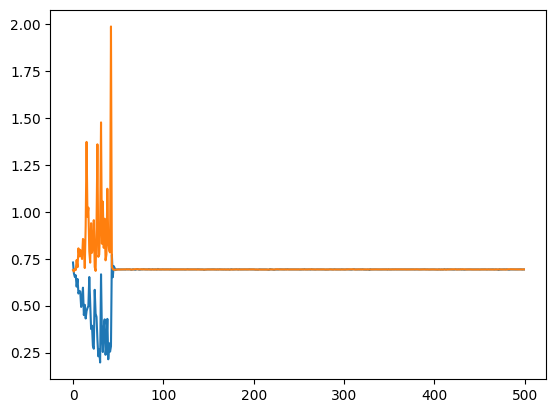

In [12]:
#### YOUR CODE FOR PLOTTING THE LOSS CURVES HERE ####
#### FEEL FREE TO REUSE CODE FROM HW2 ####
total = epochs*np.ceil(400/batch_size).astype(int)
points = 500
plt.plot(range(points),train_loss[::int(total/points)])
plt.plot(range(points),val_loss[::int(total/points)])
plt.show()

**Exercise 7:** Report your best validation accuracy and the corresponding validation loss.

**Important:** You should try to achieve at least **75%** validation accuracy.

In [13]:
best_val_acc = 0.0
corr_val_loss = 0.0

## TODO: Report your best performance

#DO NOT change the next line
print("Best Val acc: {}, Corresponding Val loss: {}".format(best_val_acc,  corr_val_loss))

Best Val acc: 0.0, Corresponding Val loss: 0.0


##  8. Create challenge output file

Here, we provide code for you to generate a submission file containing your test probabilities tensor for consideration in the challenge.

In [14]:
def generate_results_file(probabilities,nick_name):
    if probabilities.shape[0] != 400:
        'make sure your array is the correct shape'
    else:
        save_path = 'challenge_3_results_{}.pth'.format(nick_name)
        results_obj = {}
        results_obj['probabilities'] = probabilities
        torch.save(results_obj, save_path)

**Exercise 8:** Evaluate your trained model on the test set, and submit the results.

**Important:** **DO NOT** shuffle the test set for any reason! Please remember to submit this file, `challenge_3_results_nickname.pth`, in ELMS.

**Nick name rules:** Your nickname should be a single string consisting of alphanumeric characters, and your nickname should not reveal who you are! Try to be creative and unique as much as possible.

In [15]:
nick_name = 'default' ## Change this to a unique nick name!

model.eval()
for idx, batch in enumerate(test_dataloader):
    with torch.no_grad(): 
        ## TODO: Evaluate your trained model on the test set and generate `probabilities`.

generate_results_file(probabilities,nick_name)

IndentationError: expected an indented block after 'with' statement on line 5 (1491735278.py, line 8)

***Exercise 9:*** Describe the changes you made from our default settings to improve your score by editing the "answer" text block below. Be sure to identify not only which changes you made, but also why you made them. (3-5 sentences)

<span style="color:red">Answer: </span>


***Exercise 10:*** Provide at least 1 plot generated via matplotlib or a similar library proving that the changes you made improved performance on the validation set.

In [ ]:
#### YOUR MATPLOTLIB CODE HERE ####
#### FEEL FREE TO REUSE CODE FROM HW2 ####

train image shape: torch.Size([400, 64, 64, 3])
train labels shape: torch.Size([400])


IndexError: index 5 is out of bounds for axis 0 with size 5

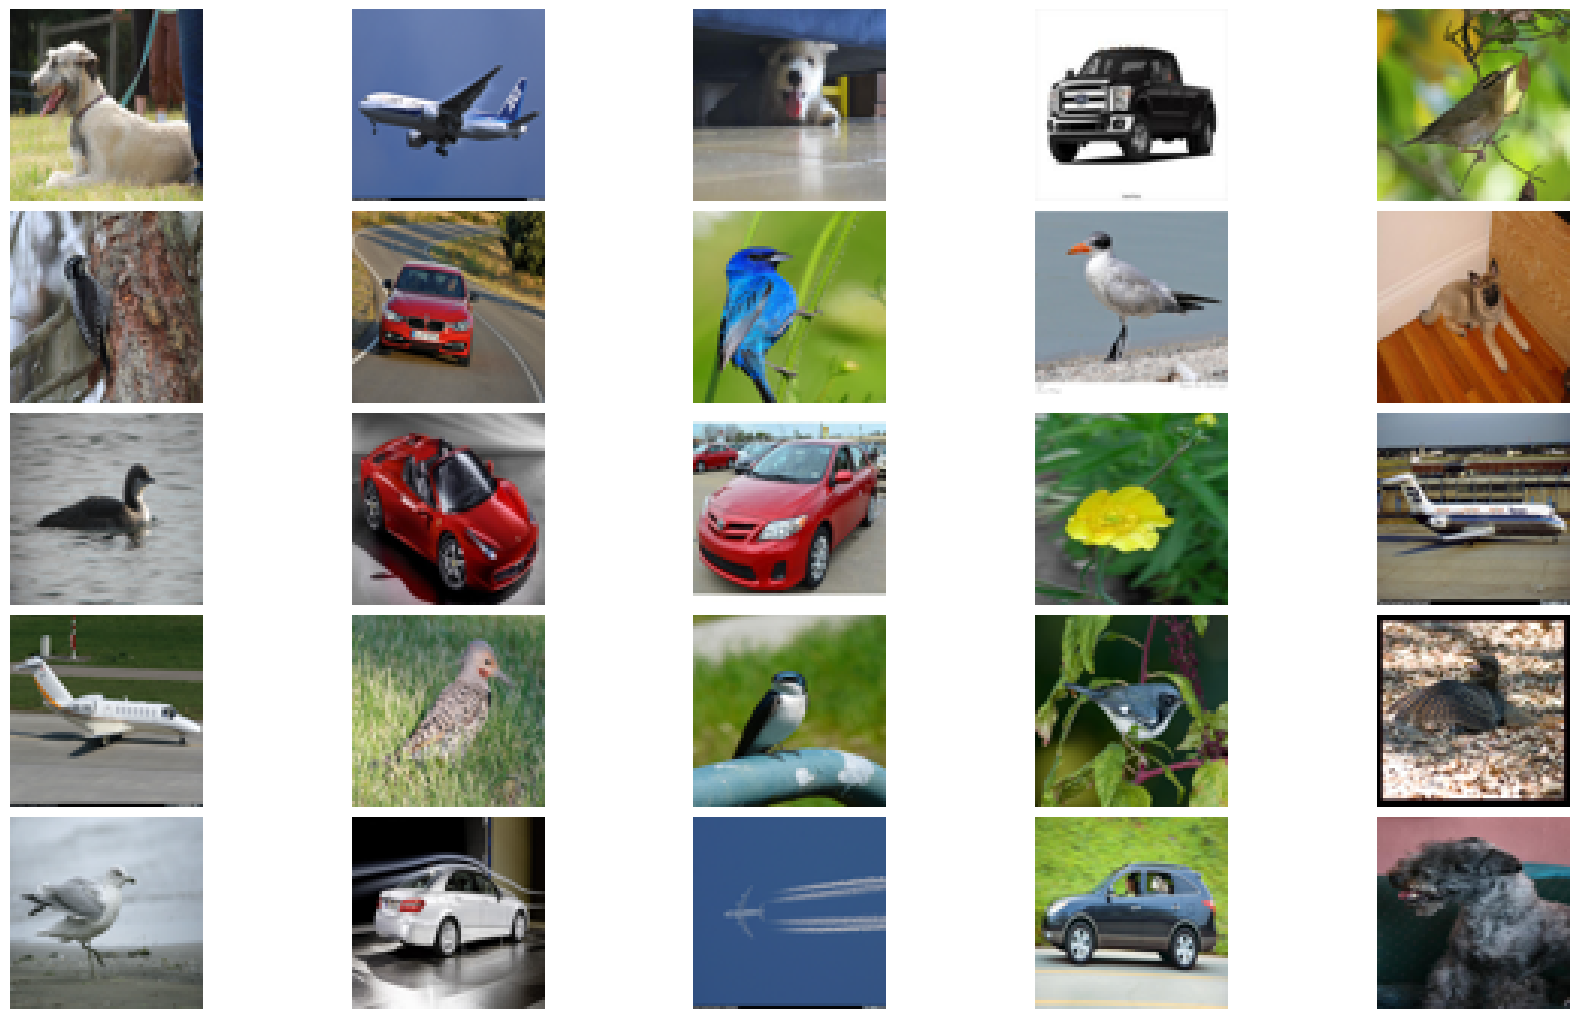

In [648]:
dataset = torch.load('toy_dataset.pth')
## TODO: Change this
print('train image shape:', dataset['train_images'].shape)
print('train labels shape:', dataset['train_labels'].shape)


def plotToy(figName, images):
    fig = plt.figure(figsize=(20.5, 12)) 
    nrow = 5
    ncol = 5
    gs = gridspec.GridSpec(nrow, ncol,
         wspace=0.0, hspace=0.05, 
         top=1.-0.5/(nrow+1), bottom=0.5/(nrow+1), 
         left=0.5/(ncol+1), right=1-0.5/(ncol+1))

    i = 0
    for j in range(images.shape[0]):
        rgb_im = images[j].numpy().astype(np.uint8)

        ax = plt.subplot(gs[int(i / ncol), i % ncol])
        ax.imshow(rgb_im)
        ax.axis('off')
        i += 1

    plt.savefig(figName + '.png', bbox_inches='tight', pad_inches=0)
    
plotToy('toy_plot', dataset['test_images'][25:])
print("labels:", dataset['train_labels'][25:].tolist())
